In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn import tree

In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv('../data/automobile_preprocessed.csv', sep=';')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 70 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   symboling               201 non-null    int64  
 1   normalized_losses       201 non-null    int64  
 2   wheel_base              201 non-null    float64
 3   length                  201 non-null    float64
 4   width                   201 non-null    float64
 5   height                  201 non-null    float64
 6   curb_weight             201 non-null    int64  
 7   num_of_cylinders        201 non-null    int64  
 8   engine_size             201 non-null    int64  
 9   bore                    201 non-null    float64
 10  stroke                  201 non-null    float64
 11  compression_ratio       201 non-null    float64
 12  horsepower              201 non-null    float64
 13  peak_rpm                201 non-null    float64
 14  city_mpg                201 non-null    in

In [5]:
df.price.max()

45400.0

In [6]:
for key in df.columns:
    print('{} have shape {}'.format(key, df[key].unique().shape))

print(df.columns)

symboling have shape (6,)
normalized_losses have shape (51,)
wheel_base have shape (52,)
length have shape (73,)
width have shape (43,)
height have shape (49,)
curb_weight have shape (169,)
num_of_cylinders have shape (7,)
engine_size have shape (43,)
bore have shape (39,)
stroke have shape (37,)
compression_ratio have shape (32,)
horsepower have shape (59,)
peak_rpm have shape (23,)
city_mpg have shape (29,)
highway_mpg have shape (30,)
price have shape (186,)
make_alfa-romero have shape (2,)
make_audi have shape (2,)
make_bmw have shape (2,)
make_chevrolet have shape (2,)
make_dodge have shape (2,)
make_honda have shape (2,)
make_isuzu have shape (2,)
make_jaguar have shape (2,)
make_mazda have shape (2,)
make_mercedes-benz have shape (2,)
make_mercury have shape (2,)
make_mitsubishi have shape (2,)
make_nissan have shape (2,)
make_peugot have shape (2,)
make_plymouth have shape (2,)
make_porsche have shape (2,)
make_renault have shape (2,)
make_saab have shape (2,)
make_subaru have 

### Найдем аномалии, избавимся от них

In [7]:
from sklearn import svm

Проверим действие One class SVM на значениях

Перебор gamma, nu выполнялся с помощью цикла for

In [8]:
numeric_cols = np.array(['symboling', 'normalized_losses', 'wheel_base', 'length', 'width',
       'height', 'curb_weight', 'num_of_cylinders', 'engine_size', 'bore',
       'stroke', 'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg',
       'highway_mpg'])
X_numeric_big = df[numeric_cols]
for col in numeric_cols:
    X_numeric_big = X_numeric_big / X_numeric_big.mean()

svm_ = svm.OneClassSVM(gamma=0.001, nu=0.01)
svm_.fit(X_numeric_big)

OneClassSVM(gamma=0.001, nu=0.01)

In [9]:
# gamma=0.104, nu=0.0104
labels = svm_.predict(X_numeric_big)

In [10]:
(labels==1).mean()

0.9850746268656716

Более 98% объектов не относятся к выбросам. Посмотрим на их распределение.

In [11]:
from matplotlib.colors import ListedColormap

good data shape: (198, 16), anomaly data shape: (3, 16)


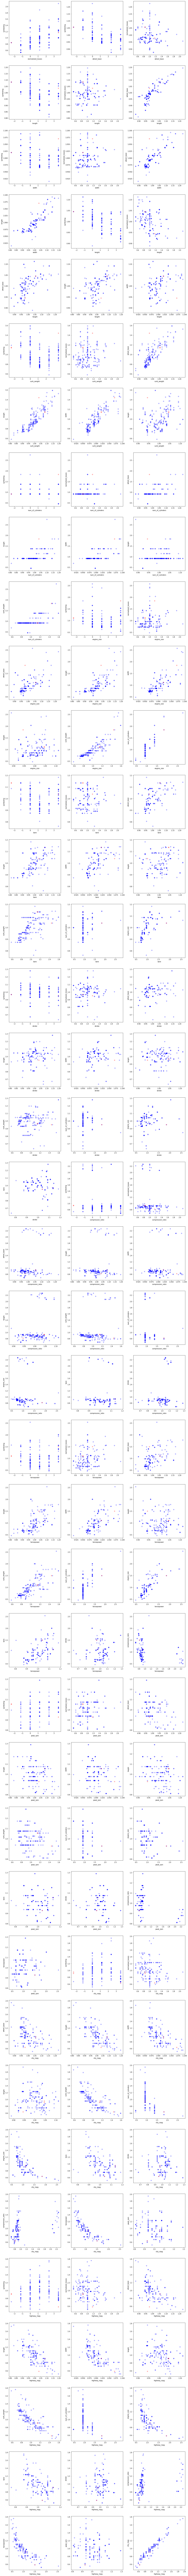

In [12]:
fig, axes = plt.subplots(nrows=40, ncols=3, figsize=(20, 300))
axes_row = axes.reshape((120,))

X_numeric_good = X_numeric_big[labels==1]
X_numeric_anom = X_numeric_big[labels==-1]

print('good data shape: {}, anomaly data shape: {}'.format(X_numeric_good.shape, X_numeric_anom.shape))

num = 0
for i, pr_1 in enumerate(numeric_cols):
    for j in range(i):
        axes_row[num].scatter(X_numeric_big[[numeric_cols[j]]], X_numeric_big[[numeric_cols[i]]], c=labels, cmap=ListedColormap(['red', 'blue']), alpha=0.3)
        
        axes_row[num].set_xlabel(numeric_cols[i])
        axes_row[num].set_ylabel(numeric_cols[j])
        num += 1

Действительно, данные значения являются выбросами и находятся на краю распределения. Избавимся от них.

In [13]:
ind_anom = np.where(labels == -1)
print(ind_anom)

(array([ 69, 190, 192], dtype=int64),)


In [14]:
df_good = df.drop(df.index[ind_anom])

### Разделим данные на обучение и тест, нормализуем их

Сделаем целевой признак в пределах (0, 1]

In [15]:
X = df_good.drop('price', axis=1)
y = df_good.price.astype('int64')
print(y)

0      13495
1      16500
2      16500
3      13950
4      17450
       ...  
196    16845
197    19045
198    21485
199    22470
200    22625
Name: price, Length: 198, dtype: int64


In [16]:
numeric_cols = np.array(['symboling', 'normalized_losses', 'wheel_base', 'length', 'width',
       'height', 'curb_weight', 'num_of_cylinders', 'engine_size', 'bore',
       'stroke', 'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg',
       'highway_mpg'])
X_numeric = X[numeric_cols]

In [17]:
categorical_cols = list(set(X.columns.values.tolist()) - set(numeric_cols))
X_categorical = X[categorical_cols]
for col in categorical_cols:
    X_categorical[col] = X_categorical[col].astype('string')

<ipython-input-17-45ba4a5426bd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_categorical[col] = X_categorical[col].astype('string')


Разделим данные на обучение и тест

In [18]:
X_train, X_test, X_train_cat, X_test_cat, X_train_num, X_test_num, y_train, y_test = train_test_split(X, X_categorical, X_numeric, y, test_size=0.15)

Номализуем значения

In [19]:
scaler = StandardScaler()
scaler.fit(X_train_num)

X_train_num_sc = scaler.transform(X_train_num)
X_test_num_sc = scaler.transform(X_test_num)

Соединяем значения воедино

In [20]:
X_train_transform = np.hstack((X_train_num_sc, X_train_cat))
X_test_transform = np.hstack((X_test_num_sc, X_test_cat))
X_transform = np.vstack((X_train_transform, X_test_transform))

# X_train_transform = X_train_num_sc
# X_test_transform = X_test_num_sc
# X_transform = np.vstack((X_train_transform, X_test_transform))

# Обучение алгоритмов

### LinearRegression

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [21]:
%%time

classifier_LR = LinearRegression()
classifier_LR.fit(X_train_transform, y_train)
y_pred_LR = classifier_LR.predict(X_test_transform)

print('R^2: {}'.format(r2_score(y_test, y_pred_LR)))
print('MSE: {}'.format(mean_squared_error(y_test, y_pred_LR)))
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred_LR, squared=False)))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred_LR)))

R^2: -8.175251716919874e+20
MSE: 7.257940375097152e+28
RMSE: 269405649070266.38
MAE: 49186517040458.8
Wall time: 7.95 ms


Как мы видим, линейная регрессия не справляется с задачей. Выполним подбор гиперпараметров.

In [22]:
%%time
parameters = {
    'fit_intercept': [True, False],
}

classifier_LR = LinearRegression()
print(classifier_LR.get_params().keys())
clf_LR = GridSearchCV(classifier_LR, parameters, cv=6)
clf_LR.fit(X_transform, y)

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize'])
Wall time: 59.8 ms


GridSearchCV(cv=6, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]})

In [23]:
best_estimator_LR = clf_LR.best_estimator_

print(best_estimator_LR)

LinearRegression()


Проверим работу лучшего алгоритма на данных

In [24]:
%%time

y_pred_LR = best_estimator_LR.predict(X_test_transform)

print('R^2: {}'.format(r2_score(y_test, y_pred_LR)))
print('MSE: {}'.format(mean_squared_error(y_test, y_pred_LR)))
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred_LR, squared=False)))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred_LR)))

R^2: 0.11031656786923671
MSE: 78985571.65833333
RMSE: 8887.382722620498
MAE: 5637.616666666667
Wall time: 2.99 ms


Видим, что работа алгоритма сильно улучшилась

### DecisionTreeRegressor 

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

In [25]:
%%time

classifier_DTC = tree.DecisionTreeRegressor()
classifier_DTC.fit(X_train_transform, y_train)
y_pred_DTC = classifier_DTC.predict(X_test_transform)

print('R^2: {}'.format(r2_score(y_test, y_pred_DTC)))
print('MSE: {}'.format(mean_squared_error(y_test, y_pred_DTC)))
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred_DTC, squared=False)))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred_DTC)))

R^2: 0.9292162891904157
MSE: 6284136.2
RMSE: 2506.817943130294
MAE: 1943.6
Wall time: 4.99 ms


Выполним подбор гиперпараметров.

In [26]:
%%time
parameters = {
    'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8],
    'min_samples_split': range(2, 30),
    'min_samples_leaf': range(1, 30),
    'criterion': ['mse']
}

classifier_DTC = tree.DecisionTreeRegressor()
print(classifier_DTC.get_params().keys())
clf_DTC = GridSearchCV(classifier_DTC, parameters, cv=6)
clf_DTC.fit(X_transform, y)

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])
Wall time: 2min 6s


GridSearchCV(cv=6, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['mse'],
                         'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': range(1, 30),
                         'min_samples_split': range(2, 30)})

In [27]:
best_estimator_DTC = clf_DTC.best_estimator_

print(best_estimator_DTC)

DecisionTreeRegressor(max_depth=1, min_samples_leaf=23)


Проверим работу лучшего алгоритма на данных

In [28]:
%%time

y_pred_DTC = best_estimator_DTC.predict(X_test_transform)

print('R^2: {}'.format(r2_score(y_test, y_pred_DTC)))
print('MSE: {}'.format(mean_squared_error(y_test, y_pred_DTC)))
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred_DTC, squared=False)))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred_DTC)))

R^2: -0.13346576799519339
MSE: 100628424.00676925
RMSE: 10031.37199024985
MAE: 6739.0263807667325
Wall time: 2.03 ms


Подберем гиперпараметры для mae

In [29]:
%%time
parameters = {
    'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8],
    'min_samples_split': range(2, 30),
    'min_samples_leaf': range(1, 15),
    'criterion': ['mae']
}

classifier_DTC = tree.DecisionTreeRegressor()
print(classifier_DTC.get_params().keys())
clf_DTC = GridSearchCV(classifier_DTC, parameters, cv=6)
clf_DTC.fit(X_transform, y)

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])
Wall time: 2min 29s


GridSearchCV(cv=6, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['mae'],
                         'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': range(1, 15),
                         'min_samples_split': range(2, 30)})

In [30]:
best_estimator_DTC = clf_DTC.best_estimator_

print(best_estimator_DTC)

DecisionTreeRegressor(criterion='mae', max_depth=1, min_samples_leaf=6)


Проверим работу лучшего алгоритма на данных

In [31]:
%%time

y_pred_DTC = best_estimator_DTC.predict(X_test_transform)

print('R^2: {}'.format(r2_score(y_test, y_pred_DTC)))
print('MSE: {}'.format(mean_squared_error(y_test, y_pred_DTC)))
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred_DTC, squared=False)))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred_DTC)))

R^2: -0.3462896713714503
MSE: 119522804.93333334
RMSE: 10932.64857815037
MAE: 6841.6
Wall time: 1.96 ms


### LASSO

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

In [32]:
%%time

classifier_Lasso = Lasso()
classifier_Lasso.fit(X_train_transform, y_train)
y_pred_Lasso = classifier_Lasso.predict(X_test_transform)

print('R^2: {}'.format(r2_score(y_test, y_pred_Lasso)))
print('MSE: {}'.format(mean_squared_error(y_test, y_pred_Lasso)))
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred_Lasso, squared=False)))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred_Lasso)))

R^2: 0.8854166426357185
MSE: 10172643.051555293
RMSE: 3189.458112525589
MAE: 2121.0003044270616
Wall time: 11 ms


Выполним подбор гиперпараметров.

In [33]:
%%time
parameters = {
    'alpha': [1.0, 2.0, 0.1, 0.5, 0.2, 0.01, 10.0, 100.0],
    'fit_intercept': [True, False],
    'max_iter': [1000, 100, 10, 1],
    'positive': [False, True]
}

classifier_Lasso = Lasso()
print(classifier_Lasso.get_params().keys())
clf_Lasso = GridSearchCV(classifier_Lasso, parameters, cv=6)
clf_Lasso.fit(X_transform, y)

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'warm_start'])


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 296609612.7549219, tolerance: 933167.7736909093
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1744388.6776361465, tolerance: 861093.9419781818
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1155446516.1766305, tolerance: 1015029.7420727274
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3433558346.9075503, tolerance: 4346494.358200001
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3729756629.3265557, tolerance: 3935762.8553000004
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2023373577.572673, tolerance: 3641368.3386000004
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2303379487.681988, tolerance: 933167.7736909093
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2344537912.6209397, tolerance: 978441.8416448485
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2848392265.1732025, tolerance: 861093.9419781818
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2649284828.2638497, tolerance: 3787731.0455
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2942464031.958674, tolerance: 3675722.4636000004
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3526942380.190258, tolerance: 3632604.5108000003
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 428070730.8772955, tolerance: 978441.8416448485
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1851226138.411202, tolerance: 861093.9419781818
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1277273442.8038025, tolerance: 1015029.7420727274
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3152746436.1424875, tolerance: 3632604.5108000003
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2766613596.5652246, tolerance: 4346494.358200001
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2403920209.726903, tolerance: 3935762.8553000004
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3814485441.3227243, tolerance: 1150488.5219175755
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3240286915.813607, tolerance: 933167.7736909093
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3424375599.779091, tolerance: 978441.8416448485
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3194639580.19574, tolerance: 3787731.0455
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3211240210.163723, tolerance: 3675722.4636000004
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3737309315.434098, tolerance: 3632604.5108000003
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: O

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1163638203.5643468, tolerance: 861093.9419781818
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 637900121.1063595, tolerance: 1015029.7420727274
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 427746877.47218513, tolerance: 1114218.9282266668
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2709353601.09548, tolerance: 3632604.5108000003
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2210765913.7695913, tolerance: 4346494.358200001
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1500842398.3890672, tolerance: 3935762.8553000004
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2938249951.827118, tolerance: 978441.8416448485
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3156927496.0392475, tolerance: 861093.9419781818
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3704360110.9581046, tolerance: 1015029.7420727274
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3843088409.2513456, tolerance: 978441.8416448485
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3699721711.8922815, tolerance: 861093.9419781818
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4075189967.5993114, tolerance: 1015029.7420727274
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3539397100.2916055, tolerance: 4346494.358200001
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3950338527.8865476, tolerance: 3935762.8553000004
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3458059206.5114155, tolerance: 3641368.3386000004
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceW

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 603015283.7912726, tolerance: 861093.9419781818
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1313919863.3758245, tolerance: 1015029.7420727274
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1952638915.9111028, tolerance: 1114218.9282266668
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 790937295.2276773, tolerance: 3787731.0455
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1000040059.7558451, tolerance: 3675722.4636000004
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1771650876.1191769, tolerance: 3632604.5108000003
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 293320290.0315466, tolerance: 1015029.7420727274
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1048955969.1686344, tolerance: 1114218.9282266668
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 891852781.2699995, tolerance: 1150488.5219175755
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

Wall time: 3.57 s


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 891823531.0288534, tolerance: 3675722.4636000004
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 747594965.7530861, tolerance: 3632604.5108000003
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 853643332.4358091, tolerance: 4346494.358200001
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

GridSearchCV(cv=6, estimator=Lasso(),
             param_grid={'alpha': [1.0, 2.0, 0.1, 0.5, 0.2, 0.01, 10.0, 100.0],
                         'fit_intercept': [True, False],
                         'max_iter': [1000, 100, 10, 1],
                         'positive': [False, True]})

In [34]:
best_estimator_Lasso = clf_Lasso.best_estimator_

print(best_estimator_Lasso)

Lasso(alpha=100.0, max_iter=1, positive=True)


Проверим работу лучшего алгоритма на данных

In [35]:
%%time

y_pred_Lasso = best_estimator_Lasso.predict(X_test_transform)

print('R^2: {}'.format(r2_score(y_test, y_pred_Lasso)))
print('MSE: {}'.format(mean_squared_error(y_test, y_pred_Lasso)))
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred_Lasso, squared=False)))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred_Lasso)))

R^2: 0.04896818929223057
MSE: 84432044.61401324
RMSE: 9188.691126271098
MAE: 5986.014911999097
Wall time: 1.99 ms


### Ridge

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

In [36]:
%%time

classifier_Ridge = Ridge()
classifier_Ridge.fit(X_train_transform, y_train)
y_pred_Ridge = classifier_Ridge.predict(X_test_transform)

print('R^2: {}'.format(r2_score(y_test, y_pred_Ridge)))
print('MSE: {}'.format(mean_squared_error(y_test, y_pred_Ridge)))
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred_Ridge, squared=False)))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred_Ridge)))

R^2: 0.8974820651836826
MSE: 9101481.9364518
RMSE: 3016.8662443754115
MAE: 2159.9436136535355
Wall time: 5.98 ms


Выполним подбор гиперпараметров.

In [37]:
%%time
parameters = {
    'alpha': [1.0, 2.0, 0.1, 0.5, 0.2, 0.01, 10.0, 100.0],
    'fit_intercept': [True, False],
    'max_iter': [1000, 100, 10, 1]
}

classifier_Ridge = Ridge()
print(classifier_Ridge.get_params().keys())
clf_Ridge = GridSearchCV(classifier_Ridge, parameters, cv=6)
clf_Ridge.fit(X_transform, y)

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'random_state', 'solver', 'tol'])
Wall time: 1.41 s


GridSearchCV(cv=6, estimator=Ridge(),
             param_grid={'alpha': [1.0, 2.0, 0.1, 0.5, 0.2, 0.01, 10.0, 100.0],
                         'fit_intercept': [True, False],
                         'max_iter': [1000, 100, 10, 1]})

In [38]:
best_estimator_Ridge = clf_Ridge.best_estimator_

print(best_estimator_Ridge)

Ridge(alpha=100.0, fit_intercept=False, max_iter=1000)


Проверим работу лучшего алгоритма на данных

In [39]:
%%time

y_pred_Ridge = best_estimator_Ridge.predict(X_test_transform)

print('R^2: {}'.format(r2_score(y_test, y_pred_Ridge)))
print('MSE: {}'.format(mean_squared_error(y_test, y_pred_Ridge)))
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred_Ridge, squared=False)))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred_Ridge)))

R^2: -0.22619793172294878
MSE: 108861130.94344781
RMSE: 10433.653767662017
MAE: 6472.488886680996
Wall time: 1.99 ms


### ElasticNet

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)

In [40]:
%%time

classifier_EN = ElasticNet()
classifier_EN.fit(X_train_transform, y_train)
y_pred_EN = classifier_EN.predict(X_test_transform)

print('R^2: {}'.format(r2_score(y_test, y_pred_EN)))
print('MSE: {}'.format(mean_squared_error(y_test, y_pred_EN)))
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred_EN, squared=False)))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred_EN)))

R^2: 0.7231807368375076
MSE: 24575851.316645015
RMSE: 4957.403687077039
MAE: 3095.7843919592465
Wall time: 6.98 ms


Выполним подбор гиперпараметров.

In [41]:
%%time
parameters = {
    'alpha': [1.0, 2.0, 0.1, 0.5, 0.2, 0.01, 10.0, 100.0],
    'fit_intercept': [True, False],
    'max_iter': [1000, 100, 10, 1],
    'positive': [False, True]
}

classifier_EN = ElasticNet()
print(classifier_EN.get_params().keys())
clf_EN = GridSearchCV(classifier_EN, parameters, cv=6)
clf_EN.fit(X_transform, y)

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'l1_ratio', 'max_iter', 'normalize', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'warm_start'])


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4158096711.085814, tolerance: 933167.7736909093
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4424553529.056612, tolerance: 978441.8416448485
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3845995735.0675163, tolerance: 861093.9419781818
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4690640435.23579, tolerance: 978441.8416448485
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4168978130.686397, tolerance: 861093.9419781818
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4854182427.178654, tolerance: 1015029.7420727274
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85060335.57231712, tolerance: 933167.7736909093
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339932813.45576096, tolerance: 978441.8416448485
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 419608509.3693943, tolerance: 861093.9419781818
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4272770589.963649, tolerance: 3787731.0455
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3935831624.0258436, tolerance: 3675722.4636000004
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4541523247.289075, tolerance: 3632604.5108000003
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4248685452.8995194, tolerance: 933167.7736909093
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4464181400.860755, tolerance: 978441.8416448485
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4011476451.21371, tolerance: 861093.9419781818
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5684015978.158152, tolerance: 3632604.5108000003
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6176562177.865898, tolerance: 4346494.358200001
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6337403240.663715, tolerance: 3935762.8553000004
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4392462840.613273, tolerance: 933167.7736909093
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4619238622.577857, tolerance: 978441.8416448485
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4138089499.5755477, tolerance: 861093.9419781818
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7517486288.082012, tolerance: 3632604.5108000003
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8719572686.110899, tolerance: 4346494.358200001
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8323776924.94124, tolerance: 3935762.8553000004
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4295637596.692197, tolerance: 978441.8416448485
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3987198367.7367287, tolerance: 861093.9419781818
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4549705846.584514, tolerance: 1015029.7420727274
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarn

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3846638803.7912636, tolerance: 3641368.3386000004
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4147129811.575658, tolerance: 3787731.0455
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3924230925.8586817, tolerance: 3675722.4636000004
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12193292921.010448, tolerance: 3641368.3386000004
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12737672969.79557, tolerance: 3787731.0455
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12139163597.190239, tolerance: 3675722.4636000004
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

Wall time: 2.7 s


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14889690905.213043, tolerance: 3641368.3386000004
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15487725966.951244, tolerance: 3787731.0455
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14988485774.698545, tolerance: 3675722.4636000004
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

GridSearchCV(cv=6, estimator=ElasticNet(),
             param_grid={'alpha': [1.0, 2.0, 0.1, 0.5, 0.2, 0.01, 10.0, 100.0],
                         'fit_intercept': [True, False],
                         'max_iter': [1000, 100, 10, 1],
                         'positive': [False, True]})

In [42]:
best_estimator_EN = clf_EN.best_estimator_

print(best_estimator_EN)

ElasticNet(alpha=2.0, fit_intercept=False, positive=True)


Проверим работу лучшего алгоритма на данных

In [43]:
%%time

y_pred_EN = best_estimator_EN.predict(X_test_transform)

print('R^2: {}'.format(r2_score(y_test, y_pred_EN)))
print('MSE: {}'.format(mean_squared_error(y_test, y_pred_EN)))
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred_EN, squared=False)))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred_EN)))

R^2: -0.2749846498268189
MSE: 113192387.07298961
RMSE: 10639.191091102257
MAE: 6630.300594853165
Wall time: 1.99 ms


### Реализация линейной регрессии

In [44]:
def stochastic_gradient_step(X, y, w, train_ind, eta=0.01):
    # считаем размер шага
    L = X.shape[0]
    # Считаем градиент по формуле
    grad = X[train_ind].dot(X[train_ind].dot(w) - y[train_ind])
    # Возвращаем новые значения весов
    return w - 2 * eta * grad / L

Напишите функцию *linear_prediction*, которая принимает на вход матрицу *X* и вектор весов линейной модели *w*, а возвращает вектор прогнозов в виде линейной комбинации столбцов матрицы *X* с весами *w*.

$$\Large y = Xw$$

In [45]:
def mserror(y, y_pred):
    return np.mean((y - y_pred)**2)

In [46]:
def linear_prediction(X, w):
    return np.dot(X, w)

Функция *stochastic_gradient_descent* реализует стохастический градиентный спуск для линейной регрессии. Функция принимает на вход следующие аргументы:**
- X - матрица, соответствующая обучающей выборке
- y - вектор значений целевого признака
- w_init - вектор начальных весов модели
- eta - шаг градиентного спуска (по умолчанию 0.01)
- max_iter - максимальное число итераций градиентного спуска (по умолчанию 10000)
- max_weight_dist - максимальное евклидово расстояние между векторами весов на соседних итерациях градиентного спуска,
при котором алгоритм прекращает работу (по умолчанию 1e-8)
- seed - число, используемое для воспроизводимости сгенерированных псевдослучайных чисел (по умолчанию 42)
- verbose - флаг печати информации (например, для отладки, по умолчанию False)

На каждой итерации в вектор (список) должно записываться текущее значение среднеквадратичной ошибки. Функция должна возвращать вектор весов $w$, а также вектор (список) ошибок.

In [47]:
def stochastic_gradient_descent(X, y, w_init, eta=1e-2, max_iter=1e4,
                                min_weight_dist=1e-8, seed=42, verbose=False):
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # Инициализируем вектор весов
    w = w_init
    # Сюда будем записывать ошибки на каждой итерации
    errors = []
    # Счетчик итераций
    iter_num = 0
    # Будем порождать псевдослучайные числа 
    # (номер объекта, который будет менять веса), а для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    np.random.seed(seed)
    # Длина выборки
    L = X.shape[0]
    # Основной цикл
    while weight_dist > min_weight_dist and iter_num < max_iter:
        # порождаем псевдослучайный 
        # индекс объекта обучающей выборки
        random_ind = np.random.randint(X.shape[0])
        # Считаем следуюзий вектор весов
        w_next = stochastic_gradient_step(X, y, w, random_ind)
        # Считаем текущую ошибку
        cur_error = mserror(y, linear_prediction(X, w_next))
        # Пересчитываем расстояние между векторами
        weight_dist = np.sqrt(np.sum((w - w_next)**2))
        # Присваиваем новое значение вектора весов
        w = w_next
        # Добавляем ошибку на данной итерации в массив
        errors.append(cur_error)
        # Переходим на следующий шаг итерации
        iter_num += 1
        
    return w, errors

In [48]:
class Regression_Linear:
    def __init__(self):
        pass
    
    def fit(self, X_train, y_train, n_iter=10**5):
        w_init = np.zeros(X_train.shape[1])
        self.w_, self.errors = stochastic_gradient_descent(X_train, y_train, w_init, max_iter=n_iter)
        pass
        
    def predict(self, X_test):
        return np.dot(X_test, self.w_)

Тестирование

In [49]:

X_train_transform_int = X_train_num_sc
    
X_test_transform_int = X_test_num_sc


In [50]:
%%time

user_classifier_LR = Regression_Linear()
user_classifier_LR.fit(X_train_transform_int, y_train.values)
y_user_pred_LR = user_classifier_LR.predict(X_test_transform_int)

'''
print('R^2: {}'.format(r2_score(y_test, y_user_pred_LR)))
print('MSE: {}'.format(mean_squared_error(y_test, y_user_pred_LR)))
print('RMSE: {}'.format(mean_squared_error(y_test, y_user_pred_LR, squared=False)))
print('MAE: {}'.format(mean_absolute_error(y_test, y_user_pred_LR)))
'''
print()


Wall time: 3.39 s


In [51]:

print('R^2: {}'.format(r2_score(y_test.values, y_user_pred_LR)))
print('MSE: {}'.format(mean_squared_error(y_test.values, y_user_pred_LR)))
print('RMSE: {}'.format(mean_squared_error(y_test.values, y_user_pred_LR, squared=False)))
print('MAE: {}'.format(mean_absolute_error(y_test.values, y_user_pred_LR)))

# print('MSE: {}'.format(np.mean((y_test.values - y_user_pred_LR)**2)))

R^2: -1.4216206281059858
MSE: 214990054.6000622
RMSE: 14662.539159370119
MAE: 13927.37388086324


На категориальных признаках данный алгоритм работает ужасно (уходит в бесконечность)

### Реализация дерева решений

Функция *tree_predict* возвращает среднее арифметическое по значениям целевого признака

In [52]:
def tree_predict(X):
    return X[:, -1].mean()

H - дисперсия ответов выборки

$\bar{y}(X)=\frac{1}{|X|}\sum_{i\in X}y_i$

$H(X)=\frac{1}{|X|}\sum_{i\in X}(y_i-\bar{y}(X))^2$

In [131]:
def tree_H(X):
    if(X.shape[0] == 0):
        return np.inf
    # ответы y в последнем столбце
    y_ = (np.sum(X[-1])) / X.shape[0]
    return (np.sum(X[-1] - y_)) / X.shape[0]

Функция *tree_Q* считает функционал ошибки, который минимизируется

In [232]:
def tree_Q(X_m, j, t):
    X_l = X_m[np.where(X_m[:, j] <= t)]
    X_r = X_m[np.where(X_m[:, j] > t)]
    return (X_l.shape[0] * tree_H(X_l) + X_r.shape[0] * tree_H(X_r)) / X_m.shape[0]

Функция *tree_select_condition* выбирает лучшие j, t на каждом шаге дерева

In [233]:
def tree_select_condition(X_train):
    best_Q = np.inf
    j = 0
    t = 0
    # Убираем целевой признак
    for i in range(X_train.shape[1] - 1):
        X_i = X_train[:, i]
        unique_t = sorted(np.array(list(set(X_i))))
        for ind_t in range(len(unique_t) - 1):
            t_i = unique_t[ind_t]
            q = tree_Q(X_train, i, t_i)
            if q < best_Q:
                j = i
                t = t_i
    return j, t

Функция *add_prediction* добавляет значения в словарь

In [234]:
def add_prediction(X_train, X_test, y):
    pred_value = tree_predict(X_train)
    for x in X_test:
        y[x] = pred_value
    return y

Функция *make_tree* отвечает за построение дерева и предсказание вершин. *idx* - индексы в массиве теста

In [241]:
def make_tree(X_train,
              X_test,
              idx,
              max_depth, 
              min_samples_split,
              y={}, 
              n_iter=0):
    # Проверяем критерии останова
    # Если на тестовой выборке нет данных значений - возврат
    if X_test.shape[0] == 0:
        return y
    # Если глубина дерева достигла максимума
    if max_depth and n_iter >= max_depth:
        return add_prediction(X_train, idx, y)
    
    # Если число различных значений целевого признака
    num_samples = len(list(set(X_train[:, -1])))
    # Или меньше, чем минимально разрешенное для деления
    if num_samples < min_samples_split:
        return add_prediction(X_train, idx, y)
    # Ищем j, t
    j, t = tree_select_condition(X_train)
    # Разбивает тренировочную и тестовую выборку на 2 части
    X_train_j = X_train[:, j]
    X_test_j = X_test[:, j]
    X_l = X_train[np.where(X_train_j <= t)]
    X_r = X_train[np.where(X_train_j > t)]
    idx_l = np.where(X_test_j <= t)
    idx_r = np.where(X_test_j > t)
    X_test_l = X_test[idx_l]
    X_test_r = X_test[idx_r]
    y_new = make_tree(X_l, X_test_l, idx[idx_l], max_depth, min_samples_split, y, n_iter + 1)
    return make_tree(X_r, X_test_r, idx[idx_r], max_depth, min_samples_split, y_new, n_iter + 1)

In [242]:
class Regression_Decision_Tree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        pass
    
    def fit(self, X_train, y_train):
        self.X = np.hstack((X_train, y_train.reshape((-1, 1))))
        pass
        
    def predict(self, X_test):
        idx = np.array([i for i in range(X_test.shape[0])])
        pred_dict = make_tree(self.X, X_test, idx, 
                              max_depth=self.max_depth, 
                              min_samples_split=self.min_samples_split)
        pred = np.array(list(map(lambda x: pred_dict[x], idx)))
        return pred

Тестирование

In [243]:
X_train_transform_int = X_train_num_sc

X_test_transform_int = X_test_num_sc

In [246]:
%%time

user_classifier_DT = Regression_Decision_Tree()
user_classifier_DT.fit(X_train_transform_int, y_train.values)
y_user_pred_DT = user_classifier_DT.predict(X_test_transform_int)
print(y_user_pred_DT)

[14489. 16515.  7295. 40960. 32528.  6849.  5348.  6938. 15750.  8358.
 32528. 14489. 36880.  9495.  8249.  8845. 18150.  6989.  9279.  7295.
 15750.  9279. 17075.  5151.  6918. 16500. 11259. 15510.  8495. 12440.]
Wall time: 492 ms


In [247]:

print('R^2: {}'.format(r2_score(y_test.values, y_user_pred_DT)))
print('MSE: {}'.format(mean_squared_error(y_test.values, y_user_pred_DT)))
print('RMSE: {}'.format(mean_squared_error(y_test.values, y_user_pred_DT, squared=False)))
print('MAE: {}'.format(mean_absolute_error(y_test.values, y_user_pred_DT)))

# print('MSE: {}'.format(np.mean((y_test.values - y_user_pred_LR)**2)))

R^2: 0.8161721421267054
MSE: 16320129.066666666
RMSE: 4039.817949693608
MAE: 2504.733333333333


### Реализация Elastic Net

$Q = 1 / (2 * n_{samples}) * ||y - Xw||^2_2
+ alpha * l1_{ratio} * ||w||_1
+ 0.5 * alpha * (1 - l1_{ratio}) * ||w||^2_2 \rightarrow min$

$grad Q $

In [251]:
def stochastic_gradient_step_EN(X, y, w, train_ind, eta=0.01, alpha=0, l1_ratio=0.5):
    # считаем размер шага
    L = X.shape[0]
    # Считаем градиент по формуле
    grad_main = X[train_ind].dot(X[train_ind].dot(w) - y[train_ind])
    grad_w1 = np.array([1 if w_i >= 0 else -1 for w_i in w])
    grad_w2 = w
    # Возвращаем новые значения весов
    return w - eta * grad_main / L + alpha * l1_ratio * grad_w1 + alpha * (1 - l1_ratio) * grad_w2

Напишите функцию *linear_prediction*, которая принимает на вход матрицу *X* и вектор весов линейной модели *w*, а возвращает вектор прогнозов в виде линейной комбинации столбцов матрицы *X* с весами *w*.

$$\Large y = Xw$$

Функция *stochastic_gradient_descent* реализует стохастический градиентный спуск для линейной регрессии. Функция принимает на вход следующие аргументы:**
- X - матрица, соответствующая обучающей выборке
- y - вектор значений целевого признака
- w_init - вектор начальных весов модели
- eta - шаг градиентного спуска (по умолчанию 0.01)
- max_iter - максимальное число итераций градиентного спуска (по умолчанию 10000)
- max_weight_dist - максимальное евклидово расстояние между векторами весов на соседних итерациях градиентного спуска,
при котором алгоритм прекращает работу (по умолчанию 1e-8)
- seed - число, используемое для воспроизводимости сгенерированных псевдослучайных чисел (по умолчанию 42)
- verbose - флаг печати информации (например, для отладки, по умолчанию False)

На каждой итерации в вектор (список) должно записываться текущее значение среднеквадратичной ошибки. Функция должна возвращать вектор весов $w$, а также вектор (список) ошибок.

In [252]:
def stochastic_gradient_descent_EN(X, y, w_init, eta=1e-2, max_iter=1e4,
                                min_weight_dist=1e-8, seed=42, verbose=False, 
                                   alpha=0, l1_ratio=0.5):
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # Инициализируем вектор весов
    w = w_init
    # Сюда будем записывать ошибки на каждой итерации
    errors = []
    # Счетчик итераций
    iter_num = 0
    # Будем порождать псевдослучайные числа 
    # (номер объекта, который будет менять веса), а для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    np.random.seed(seed)
    # Длина выборки
    L = X.shape[0]
    # Основной цикл
    while weight_dist > min_weight_dist and iter_num < max_iter:
        # порождаем псевдослучайный 
        # индекс объекта обучающей выборки
        random_ind = np.random.randint(X.shape[0])
        # Считаем следуюзий вектор весов
        w_next = stochastic_gradient_step_EN(X, y, w, random_ind, 
                                             alpha=alpha, l1_ratio=l1_ratio)
        # Считаем текущую ошибку
        cur_error = mserror(y, linear_prediction(X, w_next))
        # Пересчитываем расстояние между векторами
        weight_dist = np.sqrt(np.sum((w - w_next)**2))
        # Присваиваем новое значение вектора весов
        w = w_next
        # Добавляем ошибку на данной итерации в массив
        errors.append(cur_error)
        # Переходим на следующий шаг итерации
        iter_num += 1
        
    return w, errors

In [253]:
class Regression_EN:
    def __init__(self, alpha=0, l1_ratio=0.5):
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        pass
    
    def fit(self, X_train, y_train, n_iter=10**5):
        w_init = np.zeros(X_train.shape[1])
        self.w_, self.errors = stochastic_gradient_descent_EN(X_train, y_train, w_init, 
                                                           max_iter=n_iter,
                                                           alpha=self.alpha,
                                                          l1_ratio=self.l1_ratio)
        pass
        
    def predict(self, X_test):
        return np.dot(X_test, self.w_)

Тестирование

In [254]:

X_train_transform_int = X_train_num_sc
    
X_test_transform_int = X_test_num_sc


In [255]:
%%time

user_classifier_EN = Regression_EN()
user_classifier_EN.fit(X_train_transform_int, y_train.values)
y_user_pred_EN = user_classifier_EN.predict(X_test_transform_int)

'''
print('R^2: {}'.format(r2_score(y_test, y_user_pred_LR)))
print('MSE: {}'.format(mean_squared_error(y_test, y_user_pred_LR)))
print('RMSE: {}'.format(mean_squared_error(y_test, y_user_pred_LR, squared=False)))
print('MAE: {}'.format(mean_absolute_error(y_test, y_user_pred_LR)))
'''
print()


Wall time: 4.68 s


In [256]:
print('R^2: {}'.format(r2_score(y_test.values, y_user_pred_EN)))
print('MSE: {}'.format(mean_squared_error(y_test.values, y_user_pred_EN)))
print('RMSE: {}'.format(mean_squared_error(y_test.values, y_user_pred_EN, squared=False)))
print('MAE: {}'.format(mean_absolute_error(y_test.values, y_user_pred_EN)))

R^2: -1.4148198644792536
MSE: 214386286.80651772
RMSE: 14641.935896817666
MAE: 13923.36473512484


На категориальных признаках данный алгоритм работает ужасно (уходит в бесконечность)